# Prediction of Podiums Obtained at MotoGP Events

This exercise is performed from the perspective of potential sponsors of MotoGP Events. Specifically, the question we will attempt to address is "As a potential sponsor of MotoGP, where should I invest my money to get the highest ROI?"

MotoGP is one of the biggest motorcycle competitions in the world, with [over 400 million fans estimated worlwide in 2021](https://motochronicle.com/how-many-motogp-fans-in-the-world/). Further, MotoGP gained \\$283 million from sponsorship in 2020. Clearly, a lot of money is at stake. From the perspective of a sponsor, there are a number of different approaches that can be taken to maximize ROI. For the purpose of this exercise, we will build a predictive model based on the assumption that maximizing positive air time (time a sponsor is shown in a positive manner on mediums such as television, online streaming services, etc) will result in an increase in sales for a given sponsor.

If a model that could predict podiums increased classification precision by even 5%, sponsors utilizing this model could see potentially tens of millions more fans purchasing their products, and given that motorcycle goods aren't particularly cheap, with cheaper accessories ranging in the \\$100's of dollars and high end consumer performance motorcycles in the mid five digit range and more, this could easily increase revenue for a sponsor by billions of dollars annually.

In [11]:
import warnings

import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.compose import make_column_selector
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

from boruta import BorutaPy

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score, make_scorer, precision_score
from sklearn.model_selection import learning_curve, LearningCurveDisplay

warnings.simplefilter(action='ignore')

In [6]:
df = pd.read_csv('./data/FILTERED_ROWS.csv')
df.head()

,year,category,sequence,shortname,circuit_name,rider,rider_name,team_name,bike_name,position,points,number,country,speed,time
0,1949,500cc,1,TT,Isle of Man,6,"Daniell, Harold",?,Norton,1,10.0,NaN,GB,NaN,3:02'18.600
1,1949,500cc,1,TT,Isle of Man,7,"Lockett, John",?,Norton,2,8.0,NaN,GB,NaN,0 Lap
2,1949,500cc,1,TT,Isle of Man,8,"Lyons, Ernie",?,Velocette,3,7.0,NaN,IE,NaN,0 Lap
3,1949,500cc,1,TT,Isle of Man,5,"Bell, Artie",?,Norton,4,6.0,NaN,IE,NaN,0 Lap
4,1949,500cc,1,TT,Isle of Man,12,"Jensen, Sid",?,Triumph,5,5.0,NaN,NZ,NaN,0 Lap


## Filter to MotoGP Category
The provided dataset includes data for all MotoSport categories from the beginning of the competition in 1949 up until 2022. For the purposes of this modeling exercises, we will limit the dataset only to the *"MotoGP"* category, which officially started in 2002. While technically the MotoGP category transitioned from the 500cc category and there could be an argument for including this data for modeling purposes as well, MotoSports are a fast changing series of competitions, with advances in technology playing a strong role in who is most competitive for a given series. Including data from the pre-MotoGP era would introduce a lot of data which is not particularly relevant, including various competitors, motorcycle models, engine sizes, etc. that are no longer active participants in the current format of MotoGP. Thus, to remove noise, we will focus only on the MotoGP category.

In [8]:
motogp_df = df[df['category'] == 'MotoGP'].copy()
motogp_df.head()

,year,category,sequence,shortname,circuit_name,rider,rider_name,team_name,bike_name,position,points,number,country,speed,time
28425,2002,MotoGP,1,JPN,Suzuka,1762,"Rossi, Valentino",?,Honda,1,25.0,NaN,IT,148.0,49'32.766
28426,2002,MotoGP,1,JPN,Suzuka,1977,"Ryo, Akira",?,Suzuki,2,20.0,NaN,JP,148.0,+1.550
28427,2002,MotoGP,1,JPN,Suzuka,1647,"Checa, Carlos",?,Yamaha,3,16.0,NaN,ES,147.6,+8.353
28428,2002,MotoGP,1,JPN,Suzuka,1343,"Ito, Shinichi",?,Honda,4,13.0,NaN,JP,147.5,+10.829
28429,2002,MotoGP,1,JPN,Suzuka,1664,"Abe, Norick",?,Yamaha,5,11.0,NaN,JP,147.0,+20.423


## Initial Feature Filtering
There are a number of features included as part of this dataset which can be removed:
1. category - Only the MotoGP category is being examined
2. shortname - This provides the same information as "circuit_name" and thus can be removed
3. rider - This provides the same information as "rider_name" and thus can be removed
4. position - This will be used to create the target value, "podium", after which it can be removed
5. points - While an argument could be made for examining cumulative points over a season to better predict who would win subsuquent races, the purpose of this exercise is to determine sponsorship at the beginning of a season. Thus, this feature will be removed.
6. number - This provides the same information as "rider_name" and thus can be removed
7. speed - This information is only available after a race has finished and as such can not be used for an upcoming season prediction
8. time - This information is only available after a race has finished and as such can not be used for an upcoming season prediction

In addition, we will create the feature *"podium"* based on the *"position"* feature, which will be used as the target variable. A Podium is defined as having achieved a position of first, second, or third in a race (thus, receiving an award on the podium for the race).

In [9]:
motogp_df['podium'] = np.where(motogp_df['position'].isin([1, 2, 3]), 1, 0)
motogp_df = motogp_df.drop(['category', 'shortname', 'rider', 'position', 'points', 'number', 'speed', 'time'], axis=1)
motogp_df.head()

,year,sequence,circuit_name,rider_name,team_name,bike_name,country,podium
28425,2002,1,Suzuka,"Rossi, Valentino",?,Honda,IT,1
28426,2002,1,Suzuka,"Ryo, Akira",?,Suzuki,JP,1
28427,2002,1,Suzuka,"Checa, Carlos",?,Yamaha,ES,1
28428,2002,1,Suzuka,"Ito, Shinichi",?,Honda,JP,0
28429,2002,1,Suzuka,"Abe, Norick",?,Yamaha,JP,0


In [10]:
motogp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7023 entries, 28425 to 56338
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          7023 non-null   int64 
 1   sequence      7023 non-null   int64 
 2   circuit_name  7023 non-null   object
 3   rider_name    7023 non-null   object
 4   team_name     7023 non-null   object
 5   bike_name     7023 non-null   object
 6   country       7023 non-null   object
 7   podium        7023 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 493.8+ KB


This leaves us with 7023 samples with no missing data to work with, a sufficiently small enough dataset such that we do not need to be overly concerned with issues relating to processing times of certain models. On the flip side, this should be sufficient enough samples to adequately train data on.

As a final step before proceeding to exploratory data analysis, we will convert all features of dtype *"object"* to *"category"* to improve overall performance.

In [17]:
object_columns = make_column_selector(dtype_include=object)
motogp_df[object_columns] = motogp_df[object_columns].astype('category')
motogp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7023 entries, 28425 to 56338
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   year          7023 non-null   int64   
 1   sequence      7023 non-null   int64   
 2   circuit_name  7023 non-null   category
 3   rider_name    7023 non-null   category
 4   team_name     7023 non-null   category
 5   bike_name     7023 non-null   category
 6   country       7023 non-null   category
 7   podium        7023 non-null   int64   
dtypes: category(5), int64(3)
memory usage: 274.1 KB


# Exploratory Data Analaysis
## Target Value Balance

[Text(0, 0, 'No Podium'), Text(1, 0, 'Podium')]

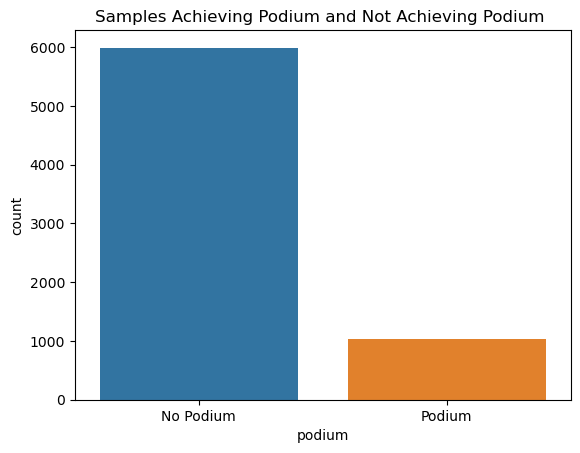

In [33]:
countplot = sns.countplot(motogp_df, x='podium')
countplot.set(title='Samples Achieving Podium and Not Achieving Podium ')
countplot.set_xticks([0, 1])
countplot.set_xticklabels(['No Podium', 'Podium'])

There is a significant imbalance between samples having a podium vs. those not having a podium, with a ratio of approximately 1:6. If this was simply a result of not having obtained a balanced dataset we would want to take steps to balance the data before modeling to prevent a unjustified bias during model training. However, in this case this is a realistic representation of the actual data. While the specific number of participants changes from season to season, for any given race, only the top three will receive a podium. Thus, whether it makes sense to balance the dataset or not is less clear.

As such, during model training, we will train models both with balanced and unbalanced datasets and compare their performance to determine which approach is more optimal.